In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse

In [2]:
#データのを選択
# data_width = "wide"
data_width = "detail"
dataname = "CH_data"
alldata = "test"

In [3]:
log = {}
if data_width == "wide":
    dropout_vals = [0.0, 0.2, 0.4, 0.6, 0.8]
elif data_width == "detail":
    dropout_vals = [0.3, 0.34, 0.38, 0.42, 0.46]
else:
    print("data_width is wide or detail")
    exit()

# ファイル名のリスト
filenames = [f"result/dropout/{dataname}_dropout{dropout_val}_predict_{alldata}.txt" for dropout_val in dropout_vals]

# 各ファイルからデータを読み込み、データフレームに変換
df_list = [pd.read_csv(filename, sep=" ", header=None) for filename in filenames]

#各データフレームの名称と色
labels = [f"dropout:{dropout_val}" for dropout_val in dropout_vals]
colors = ['red', 'blue', 'green', 'yellow', 'purple']

# 抽出した全要素をまとめるdf
all_df = pd.DataFrame()
for idx in range(len(df_list[0])):
    middle_df = pd.DataFrame()
    for df in df_list:
        middle_df = pd.concat([middle_df, df.iloc[idx]], axis=1)
    #middle_dfのindexとcolumnsを入れ替え
    middle_df = middle_df.T.reset_index(drop=True)
    # print(middle_df)
    #middle_dfをall_dfに追加
    all_df = pd.concat([all_df, middle_df], axis=0)
    #logに残す
    max_value = middle_df[1].max()
    min_value = middle_df[1].min()
    max_index = middle_df[1].idxmax()
    min_index = middle_df[1].idxmin()
    log[f"{middle_df[0][0]}_max:{dropout_vals[max_index]}"] = max_value
    log[f"{middle_df[0][0]}_min:{dropout_vals[min_index]}"] = min_value
#all_dfのindexをリセット
all_df = all_df.reset_index(drop=True)
all_df

,0,1
0,1.039322,1.134013
1,1.039322,1.107069
2,1.039322,1.096796
3,1.039322,1.074337
4,1.039322,1.055853
...,...,...
1455,5.839173,5.840689
1456,5.839173,5.888378
1457,5.839173,5.884531
1458,5.839173,5.888063


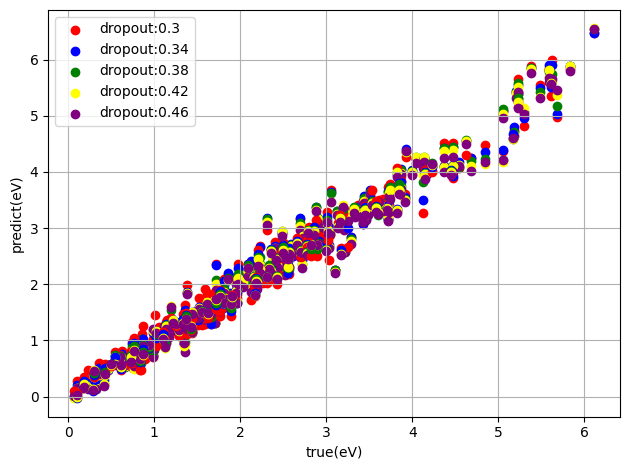

In [4]:
# 散布図のplot
fig1, ax1 = plt.subplots()
# 凡例用のハンドラとラベルを保存するリスト
handlers = []
labels_list = []
for i in range(len(all_df)):
    scatter = ax1.scatter(all_df[0][i], all_df[1][i], color=colors[i%len(labels)], label=labels[i%len(labels)])
    # 同じラベルが既にリストに存在しない場合に、ハンドラとラベルを追加
    if labels[i%len(labels)] not in labels_list:
        handlers.append(scatter)
        labels_list.append(labels[i%len(labels)])
# 軸の名前を設定
plt.legend(handles=handlers, labels=labels_list)
plt.xlabel('true(eV)')
plt.ylabel('predict(eV)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'resultplot/dropout{data_width}_scatter.png')
plt.show(block=False)
plt.close()

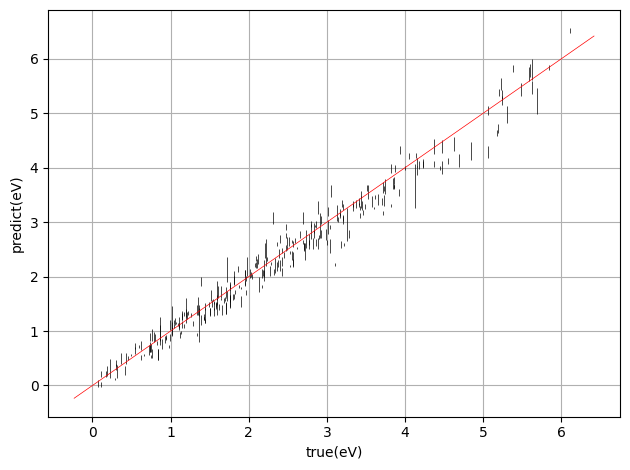

In [5]:
#エラーバーのplot
fig2, ax2 = plt.subplots()
list = []
for i in range(len(all_df)):
    list.append(all_df[1][i])
    if i % len(labels) == len(labels)-1:
        plt.vlines(all_df[0][i], min(list), max(list), color='black', linewidth=0.5)
        list = []
# 軸の名前を設定
plt.xlabel('true(eV)')
plt.ylabel('predict(eV)')
x = np.linspace(*plt.xlim())  # x軸の範囲を取得
plt.plot(x, x, color='red', linewidth=0.5)  # y=xのグラフを描画
plt.grid(True)
plt.tight_layout()
plt.savefig(f"resultplot/dropout{data_width}.png")
plt.show(block=False)
plt.close()